# XGBoost model

In [178]:
import pandas as pd
import numpy as np
#from sklearn import cross_validation
from sklearn.model_selection import cross_validate
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

import modify_dataset as md

In [144]:
#Common error function to minimize: Root Mean Square Percentage Error
#We will have to integrate our loss function with xgboost

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe


In [145]:
df = pd.read_csv("dataset/preprocessed_train_PCA.csv")

In [146]:
df = df.drop(['NumberOfCustomers'], axis=1)
#df = df.drop(['Region','Events'], axis=1)
# I could leave events

In [147]:
df = df[df.IsOpen == 1]

In [148]:
#for now let's drop unusable categorical vars
df = df.drop(['StoreType','AssortmentType','Events'], axis=1)

In [149]:
df.head(20).T

,0,1,2,3,5,6,7,8,9,10,12,13,14,15,16,17,19,20,21,22
Unnamed: 0,0,1,2,3,5,6,7,8,9,10,12,13,14,15,16,17,19,20,21,22
StoreID,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
Date,01/03/2016,02/03/2016,04/03/2016,05/03/2016,07/03/2016,08/03/2016,09/03/2016,10/03/2016,11/03/2016,12/03/2016,14/03/2016,15/03/2016,16/03/2016,17/03/2016,18/03/2016,19/03/2016,21/03/2016,22/03/2016,23/03/2016,24/03/2016
IsHoliday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
IsOpen,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
HasPromotions,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1
NearestCompetitor,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326
Region,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
NumberOfSales,5676,8111,8300,7154,10110,9019,8804,7823,7989,5895,6348,4738,6014,6087,6962,6618,9183,8155,7109,8041
Region_AreaKM2,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643


In [150]:
df.shape

(433958, 44)

In [151]:
train = md.get_fake_train2(df)

In [152]:
train.shape

(396420, 44)

In [153]:
test = md.get_fake_test2(df)
test.shape

(37538, 44)

In [154]:
#print("Load the training, test and store data using pandas")
#train = pd.read_csv("train.csv",low_memory=False)
#test = pd.read_csv("test.csv")
#store = pd.read_csv("store.csv")

### Selecting predictive features 

In [155]:
from pprint import pprint
features = list(train.columns.values)
features.remove('NumberOfSales')
features.remove('StoreID')
features.remove('IsOpen')
#features.remove('Region')
#features.remove('Region_GDP')
#features.remove('Max_Dew_PointC')
#features.remove('Min_Sea_Level_PressurehPa')
#features.remove('Precipitationmm')
#features.remove('Mean_Dew_PointC')
#features.remove('Min_TemperatureC')
#features.remove('Events_Thunderstorm')
#features.remove('Events_Fog')
features.remove('D_DayOfweek')
features.remove('Date')
print("features")

pprint(features)

features
['Unnamed: 0',
 'IsHoliday',
 'HasPromotions',
 'NearestCompetitor',
 'Region',
 'Region_AreaKM2',
 'Region_GDP',
 'Region_PopulationK',
 'CloudCover',
 'Max_VisibilityKm',
 'Min_VisibilitykM',
 'WindDirDegrees',
 'D_Day',
 'D_DayOfYear',
 'D_Month',
 'D_Year',
 'StoreType_SuperMarket',
 'StoreType_HyperMarket',
 'StoreType_StandardMarket',
 'StoreType_ShoppingCenter',
 'AssortmentType_General',
 'AssortmentType_WithNFDept',
 'AssortmentType_WithFishDept',
 'MeanStoreSales',
 'MeanRegionSales',
 'D_DayOfWeek_cos',
 'D_DayOfWeek_sin',
 'p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'p6',
 'p7',
 'p8',
 'p9',
 'p10',
 'p11',
 'p12']


In [156]:
features.remove('p11')
features.remove('p12')
features.remove('p7')
features.remove('p9')

In [157]:
params = {"objective": "reg:linear",
          "eta": 0.2,
          "max_depth": 8,
          "subsample": 1.0,
          "colsample_bytree": 0.3, #0.3
          "silent": 1,
          "nthread":-1,
          #added as a test
          "eval_metric": "rmse",
          "seed": 23
          #"gamma": 2  #added as a test
          }

#reg_alpha 
#reg_lambda
num_trees = 100 #400

In [177]:
from xgboost.sklearn import XGBRegressor # wrapper
# XGB with sklearn wrapper
# the same parameters as for xgboost model
params_sk = {'max_depth': 8, 
            'n_estimators': 100, # the same as num_rounds in xgboost
            'objective': 'reg:linear', 
            'subsample': 1.0, 
            'colsample_bytree': 0.3, 
            'learning_rate': 0.1, 
            'seed': 23}     

skrg = XGBRegressor(**params_sk)

skrg.fit(X_train[features], np.log(X_train["NumberOfSales"] + 1))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=23, silent=True,
       subsample=1.0)

In [183]:
import scipy.stats as st

params_grid = {  
    'learning_rate': st.uniform(0.01, 0.3),
    'max_depth': list(range(10, 20, 2)),
    'gamma': st.uniform(0, 60),
    'reg_alpha': st.expon(0, 30)}

search_sk = RandomizedSearchCV(skrg, params_grid, cv = 5, verbose=3) # 5 fold cross validation
search_sk.fit(X_test[features], np.log(X_test["NumberOfSales"] + 1))

# best parameters
print(search_sk.best_params_); print(search_sk.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] gamma=7.506303383148289, learning_rate=0.09692512706657527, max_depth=18, reg_alpha=19.326934168592672 
[CV]  gamma=7.506303383148289, learning_rate=0.09692512706657527, max_depth=18, reg_alpha=19.326934168592672, score=0.776370311590394, total=   2.6s
[CV] gamma=7.506303383148289, learning_rate=0.09692512706657527, max_depth=18, reg_alpha=19.326934168592672 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV]  gamma=7.506303383148289, learning_rate=0.09692512706657527, max_depth=18, reg_alpha=19.326934168592672, score=0.7772059166742011, total=   2.6s
[CV] gamma=7.506303383148289, learning_rate=0.09692512706657527, max_depth=18, reg_alpha=19.326934168592672 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


[CV]  gamma=7.506303383148289, learning_rate=0.09692512706657527, max_depth=18, reg_alpha=19.326934168592672, score=0.787059031067972, total=   2.7s
[CV] gamma=7.506303383148289, learning_rate=0.09692512706657527, max_depth=18, reg_alpha=19.326934168592672 
[CV]  gamma=7.506303383148289, learning_rate=0.09692512706657527, max_depth=18, reg_alpha=19.326934168592672, score=0.7895803275542409, total=   2.7s
[CV] gamma=7.506303383148289, learning_rate=0.09692512706657527, max_depth=18, reg_alpha=19.326934168592672 
[CV]  gamma=7.506303383148289, learning_rate=0.09692512706657527, max_depth=18, reg_alpha=19.326934168592672, score=0.7146113911858655, total=   2.6s
[CV] gamma=59.83696334735638, learning_rate=0.043488743067732705, max_depth=18, reg_alpha=1.4240904481983547 
[CV]  gamma=59.83696334735638, learning_rate=0.043488743067732705, max_depth=18, reg_alpha=1.4240904481983547, score=0.5391357471571234, total=   2.7s
[CV] gamma=59.83696334735638, learning_rate=0.043488743067732705, max_de

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.5min finished


{'gamma': 7.506303383148289, 'learning_rate': 0.09692512706657527, 'max_depth': 18, 'reg_alpha': 19.326934168592672}
0.7689657692039589


In [158]:
#split in train and test (not real test which is called test and is the fake test provided by md)
X_train, X_test = train_test_split(train, test_size=0.05)
#X_train, X_test = train.head(len(train) - val_size), train.tail(val_size)

In [159]:
dtrain = xgb.DMatrix(X_train[features], np.log(X_train["NumberOfSales"] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test["NumberOfSales"] + 1))
#dtest = xgb.DMatrix(test[features])

In [160]:
X_train.shape

(376599, 44)

In [161]:
X_test.shape

(19821, 44)

In [162]:
#watchlist = [(dvalid, 'test'), (dtrain, 'train')]
#gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, feval=rmspe_xg, verbose_eval=True)

In [163]:
watchlist = [(dvalid, 'test'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, verbose_eval=True)

[0]	test-rmse:6.33582	train-rmse:6.33861
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 20 rounds.
[1]	test-rmse:5.07302	train-rmse:5.07558
[2]	test-rmse:4.06097	train-rmse:4.06326
[3]	test-rmse:3.25415	train-rmse:3.25609
[4]	test-rmse:2.60678	train-rmse:2.60852
[5]	test-rmse:2.0916	train-rmse:2.09328
[6]	test-rmse:1.68149	train-rmse:1.68296
[7]	test-rmse:1.3548	train-rmse:1.35627
[8]	test-rmse:1.09052	train-rmse:1.09182
[9]	test-rmse:0.882696	train-rmse:0.88435
[10]	test-rmse:0.719671	train-rmse:0.721337
[11]	test-rmse:0.587413	train-rmse:0.589032
[12]	test-rmse:0.487317	train-rmse:0.489071
[13]	test-rmse:0.408958	train-rmse:0.410862
[14]	test-rmse:0.344904	train-rmse:0.346938
[15]	test-rmse:0.296835	train-rmse:0.298944
[16]	test-rmse:0.260192	train-rmse:0.262609
[17]	test-rmse:0.235233	train-rmse:0.237945
[18]	test-rmse:0.216091	train-rmse:0.218817
[19]	test-rmse:0.201901	train-rmse:0.204665
[20]	t

### Plotting Trees

In [164]:
#plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = (15, 6)
#plt.rcParams['figure.figsize'] = [40.0,20.0]
#plt.rcParams['figure.dpi']=400
#plt.rcParams.update({'font.size': 30})

In [165]:
from xgboost import plot_tree
#plot_tree(gbm)


In [166]:
#xgb.to_graphviz(gbm, num_trees=0, rankdir='LR', **{'size':str(10)})

In [167]:
#xgb.to_graphviz(gbm, num_trees=1, rankdir='LR', **{'size':str(10)})

### Validating

In [168]:
print("Validating")
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

Validating
error 0.11917583518401173


RMSE

C:\Users\Mirko\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


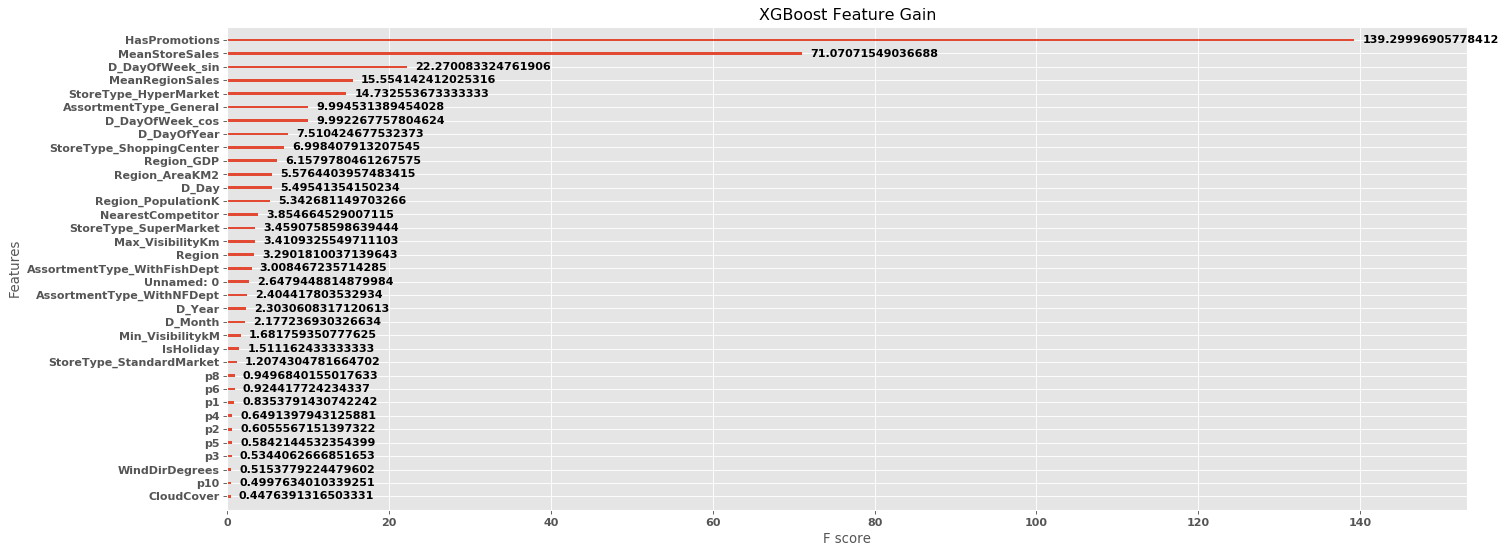

In [169]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="gain")
plt.title("XGBoost Feature Gain")
plt.show()

C:\Users\Mirko\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


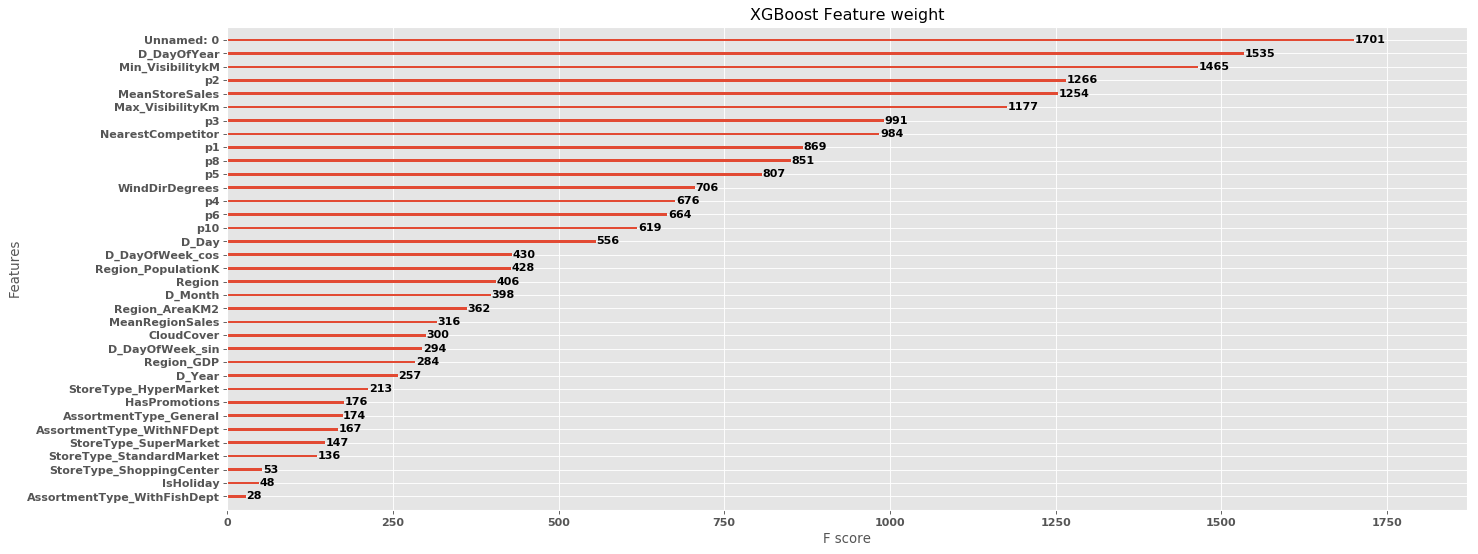

In [170]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="weight")
plt.title("XGBoost Feature weight")
plt.show()

C:\Users\Mirko\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


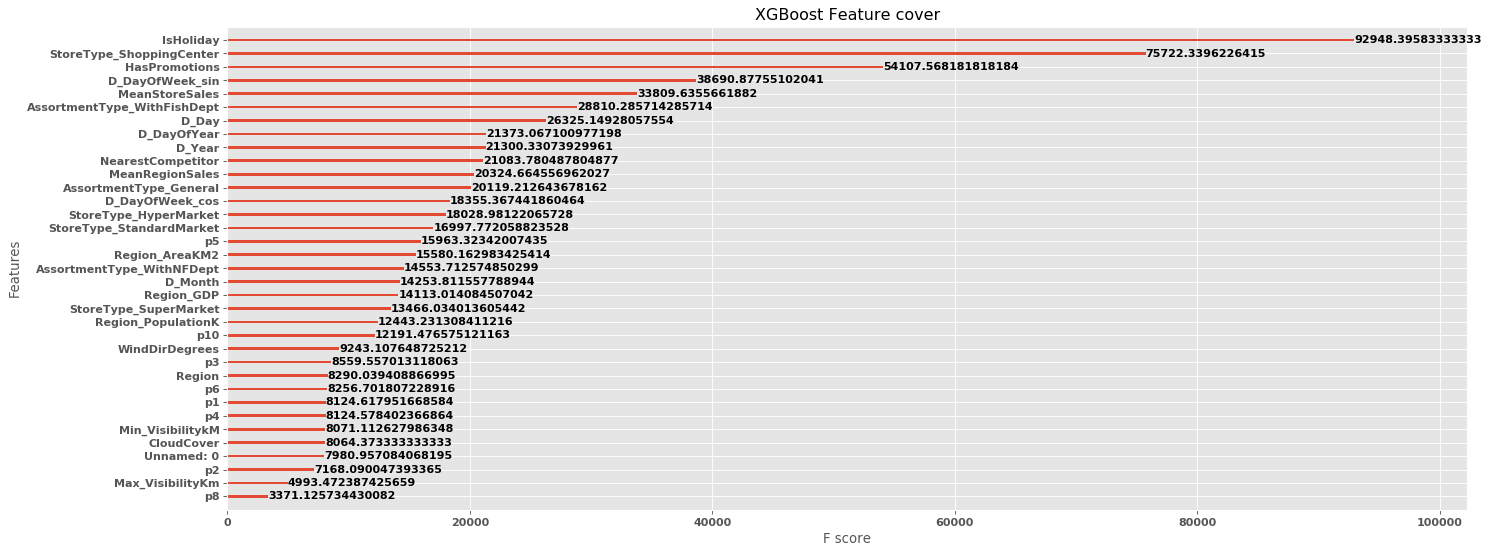

In [171]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="cover")
plt.title("XGBoost Feature cover")
plt.show()

### Predict on fake test set

In [172]:
train_probs = gbm.predict(xgb.DMatrix(test[features]))

In [173]:
test['_NumberOfSales'] = np.exp(gbm.predict(xgb.DMatrix(test[features])))-1

C:\Users\Mirko\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## BIP Error

In [174]:
from BIP_error import get_BIP_error
error1 = get_BIP_error(test)

Number of regions identified: 11
BIP total error: 0.057476103163706334


In [51]:
diff=test['NumberOfSales']-test['_NumberOfSales']

In [52]:
diff.head(15).T

670    -212.747070
671    2070.460938
672    -356.118652
674    -473.026855
675   -1303.062988
677   -1848.073242
678   -2160.660156
679   -2172.970703
680   -1432.466309
681    -185.285156
682    -684.897461
684      27.769531
685     744.705566
686   -1181.346680
687    -648.809082
dtype: float32

In [53]:
diff.mean()

-48.67221450805664

In [54]:
train_probs.shape

(36911,)

In [55]:
#test['predicted'] = pd.Series([train_probs], index=test.index)
#test['predicted']=train_probs

In [56]:
compare = test[['NumberOfSales','_NumberOfSales']]

### Saving TEST

In [57]:
#test.to_csv('./dataset/XGB5_fake_test.csv', index=False)

In [58]:
error = rmspe(test['_NumberOfSales'].values, test['NumberOfSales'].values)
print('error', error)

error 0.19567676584967392


In [59]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
14893,5468,4305.241211
14894,6795,6959.092773
14896,7035,7389.159668
14897,5437,6403.018066
14898,5725,6050.510254
14899,5143,6049.540527
14900,5589,6637.783203
14901,7520,6460.241211
14903,3927,5377.758301
14904,3682,4539.054688


In [60]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
14893,5468,4305.241211
14894,6795,6959.092773
14896,7035,7389.159668
14897,5437,6403.018066
14898,5725,6050.510254
14899,5143,6049.540527
14900,5589,6637.783203
14901,7520,6460.241211
14903,3927,5377.758301
14904,3682,4539.054688


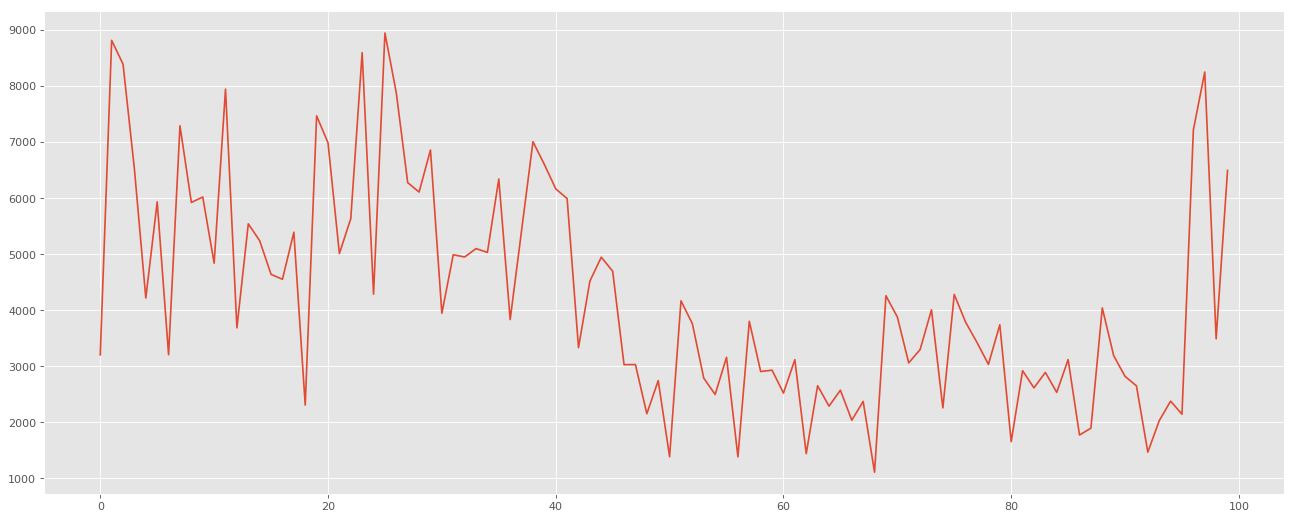

In [61]:
#REAL
start = 500
end = 600
import matplotlib.pyplot as plt

y = compare.iloc[start:end,0].values
x_coordinate = [ 1 * i for i in range(len(y)) ]
plt.plot(x_coordinate,y)
plt.show()

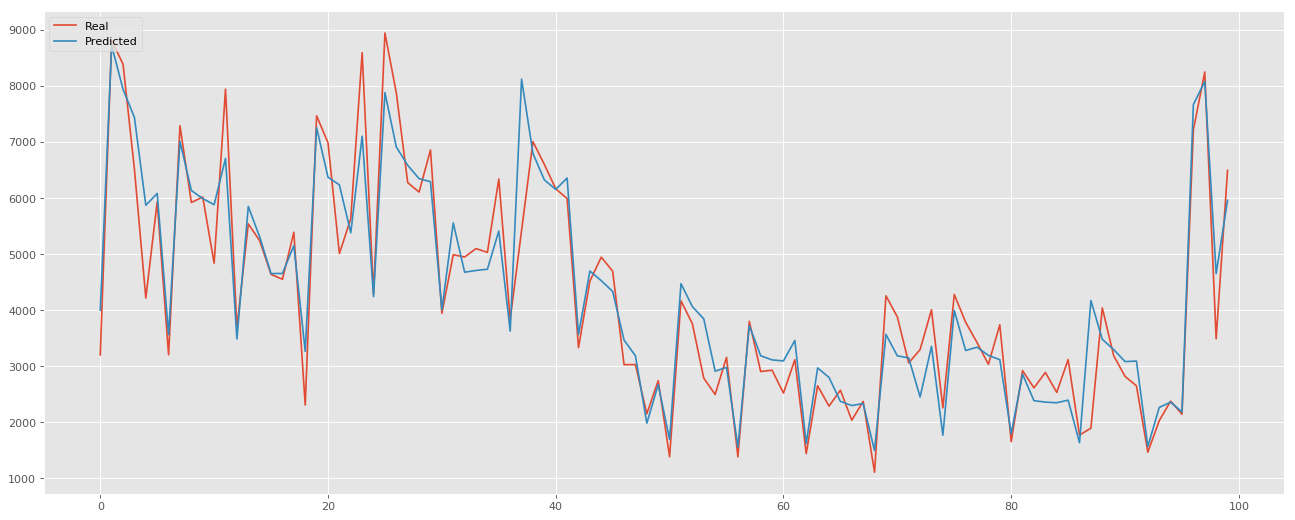

In [62]:
import matplotlib.pyplot as plt

yhat = compare.iloc[start:end:1].values
x_coordinate = [ 1 * i for i in range(len(yhat)) ]
plt.plot(x_coordinate,yhat)
plt.legend(['Real', 'Predicted'], loc='upper left')
plt.show()

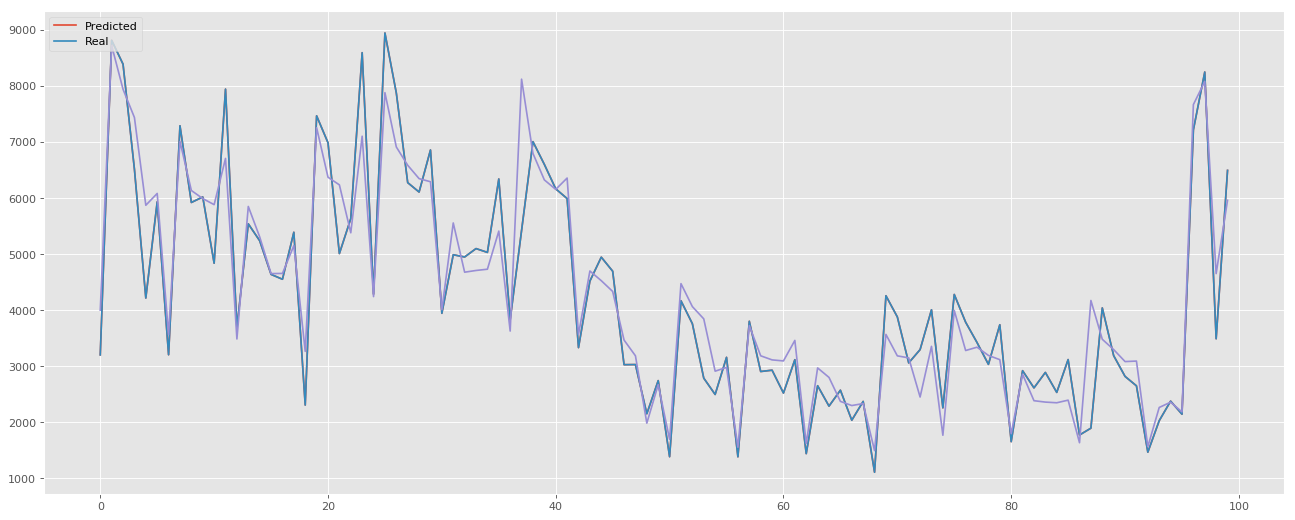

In [63]:
import matplotlib.pyplot as plt
#import matplotlib as mpl

#mpl.style.use("default")


plt.plot(x_coordinate,y)
plt.plot(x_coordinate,yhat)
plt.legend(['Predicted', 'Real'], loc='upper left')
plt.show()

In [64]:
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

ValueError: operands could not be broadcast together with shapes (19853,) (36911,) 

In [ ]:
test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
submission.to_csv("xgboost_kscript_submission.csv", index=False)

In [ ]:
Y = df.iloc[:, 3]

In [ ]:
Y